In [1]:
import pandas as pd
from chemprop2_wrapper import run_chemprop
from lgbm_wrapper import LGBMMorganCountWrapper
import seaborn as sns
from scipy.stats import pearsonr
import useful_rdkit_utils as uru
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

Read the training and test sets from csv files. 

In [2]:
train = pd.read_csv("train_mw_lt_400.csv")          #TRAIN
test = pd.read_csv("test_mw_lt_400.csv")            #TEST_LT_400
test_500_800 = pd.read_csv("test_mw_gt_500.csv")    #TEST_GT_500

Combine the training set and two test sets into one dataframe. 

In [3]:
combo_df = pd.concat([train,test,test_500_800])
combo_df.dataset.value_counts()

dataset
TRAIN          750
TEST_LT_400    250
TEST_GT_500    250
Name: count, dtype: int64

Draw a boxplot of the molecular weight distributions for the training and test sets. 

(0.0, 825.0)

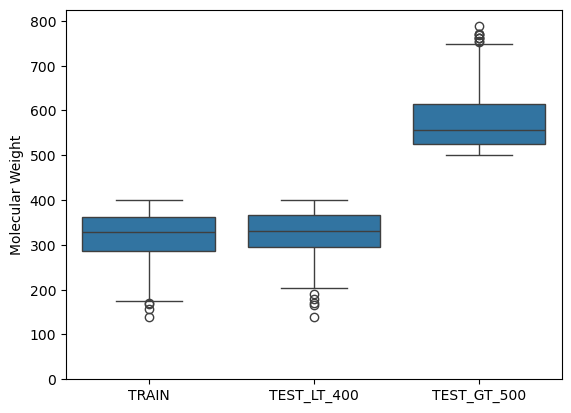

In [5]:
ax = sns.boxplot(x="dataset",y="mw",data=combo_df)
ax.set_xlabel("")
ax.set_ylabel("Molecular Weight")
ax.set_ylim(0,825)

Instantiate a Smi2Fp object from [useful_rdkit_utils](https://github.com/PatWalters/useful_rdkit_utils), this provides and easy way of generating fingerprints from SMILES. 

In [6]:
smi2fp = uru.Smi2Fp()

Add fingerprints to the training and test sets. 

In [7]:
for df in [train, test, test_500_800]:
    df['fp'] = df.SMILES.apply(smi2fp.get_np_counts)

Build a linear regression model and use it predict the molecular weights of **TEST_LT_400**. 

In [8]:
lm = LinearRegression()
lm.fit(np.stack(train.fp), train.mw)
lm_pred_le_400 = lm.predict(np.stack(test.fp))

In [9]:
chemprop_pred_le_400 = run_chemprop(train, test, "mw")

Build a model with LightGBM and use it predict the molecular weights of **TEST_LT_400**. 

In [10]:
lgbm_wrapper = LGBMMorganCountWrapper("mw")
lgbm_wrapper.fit(train)
lgbm_pred_le_400 = lgbm_wrapper.predict(test)

A quick function to draw scatterplots. 

In [11]:
def draw_regression_scatterplot(truth, pred, ax, title):
    r = pearsonr(truth,pred).statistic
    ax = sns.regplot(x=truth,y=pred, ax=ax)
    ax.text(150,800,f"r={r:.2f}")
    ax.set_xlim(0,850)
    ax.set_ylim(0,850)
    ax.set_xlabel("True Molecular Weight")
    ax.set_ylabel("Predicted Molecular Weight")
    ax.set_title(title)

Draw scatterplots of true MW vs predicted MW for the molecules with MW < 400. 

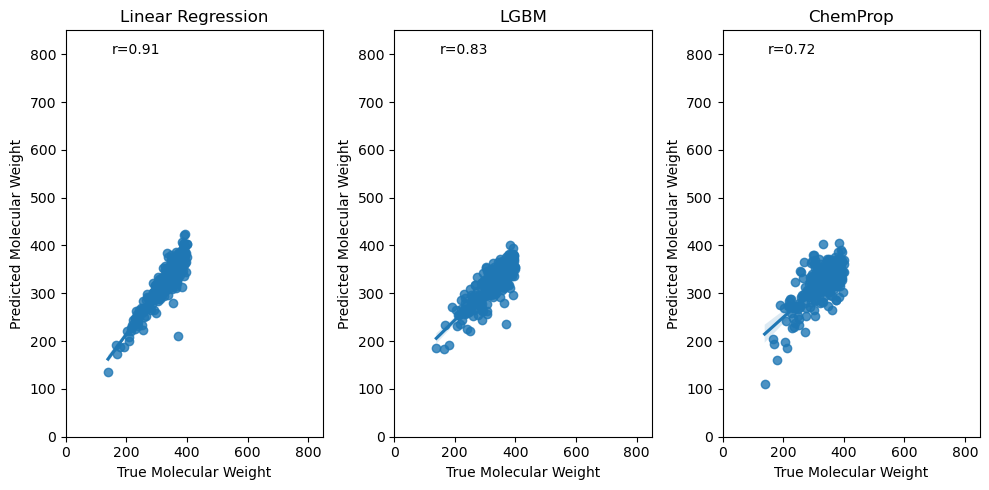

In [12]:
figure, axes = plt.subplots(1,3,figsize=(10,5))
draw_regression_scatterplot(test.mw,lm_pred_le_400,axes[0],"Linear Regression")
draw_regression_scatterplot(test.mw,lgbm_pred_le_400,axes[1],"LGBM")
draw_regression_scatterplot(test.mw,chemprop_pred_le_400,axes[2],"ChemProp")
plt.tight_layout()

Use ChemProp to to predict the MW of **TEST_GT_500**. 

In [13]:
chemprop_pred_500_800 = run_chemprop(train, test_500_800, "mw")

Use linear regression to to predict the MW of **TEST_GT_500**. 

In [14]:
lm_pred_500_800 = lm.predict(np.stack(test_500_800.fp))

Use LightGBM to predict the MW of **TEST_GT_500**. 

In [15]:
lgbm_wrapper = LGBMMorganCountWrapper("mw")
lgbm_wrapper.fit(train)
lgbm_pred_500_800 = lgbm_wrapper.predict(test_500_800)

Plot the distributions of predicted molecular weights. 

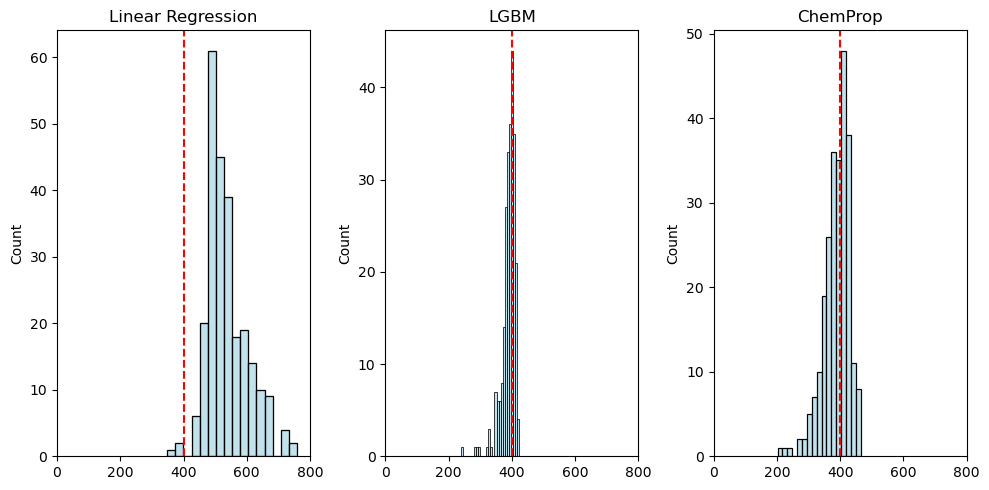

In [18]:
figure, axes = plt.subplots(1,3,figsize=(10,5))
ax = sns.histplot(lm_pred_500_800,ax=axes[0],color="lightblue")
ax.axvline(400,ls="--",color="red")
ax.set_title("Linear Regression")
ax.set_xlim(0,800)
ax = sns.histplot(lgbm_pred_500_800,ax=axes[1],color="lightblue")
ax.axvline(400,ls="--",color="red")
ax.set_title("LGBM")
ax.set_xlim(0,800)
ax = sns.histplot(chemprop_pred_500_800,ax=axes[2],color="lightblue")
ax.axvline(400,ls="--",color="red")
ax.set_xlim(0,800)
ax.set_title("ChemProp");
plt.tight_layout()

Draw scatterplots of true MW vs predicted MW for **TEST_GT_500**.

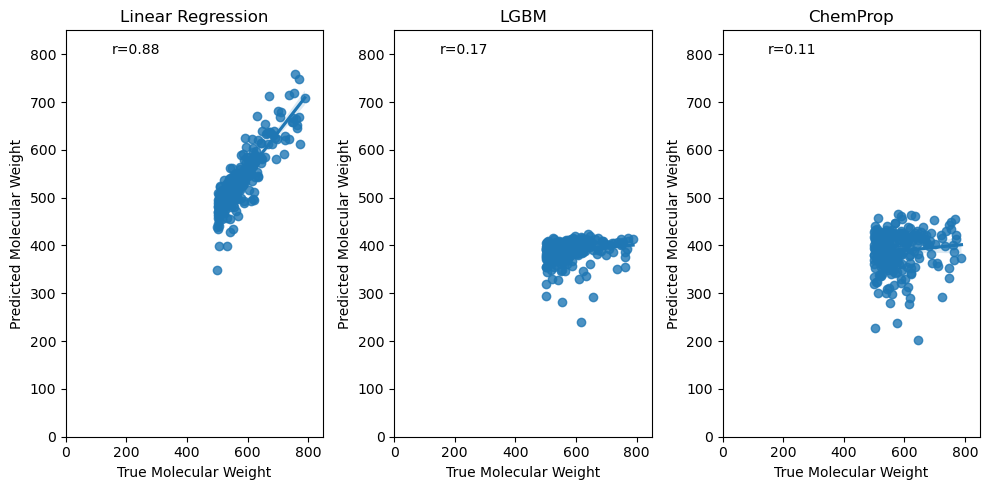

In [19]:
figure, axes = plt.subplots(1,3,figsize=(10,5))
draw_regression_scatterplot(test_500_800.mw,lm_pred_500_800,axes[0],"Linear Regression")
draw_regression_scatterplot(test_500_800.mw,lgbm_pred_500_800,axes[1],"LGBM")
draw_regression_scatterplot(test_500_800.mw,chemprop_pred_500_800,axes[2],"ChemProp")
plt.tight_layout()